In [1]:
# Chargement des packages et options de configuration

import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:2.7.3,databricks:spark-deep-learning:1.5.0-spark2.4-s_2.11 pyspark-shell --conf spark.driver.extraJavaOptions="-Dio.netty.tryReflectionSetAccessible=true",spark.hadoop.fs.s3a.endpoint=s3.eu-west-1.amazonaws.com'

In [2]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
sc = SparkContext()
spark = SparkSession.builder.master('local[*]').getOrCreate()


In [4]:
# create a spark session
path = "s3a://p8smonet/test/train/*"

images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(path)


In [5]:
images.show()

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3a://p8smonet/te...|2021-02-22 12:40:04|  5557|[FF D8 FF E0 00 1...|
|s3a://p8smonet/te...|2021-02-22 12:39:53|  5537|[FF D8 FF E0 00 1...|
|s3a://p8smonet/te...|2021-02-22 12:39:55|  5528|[FF D8 FF E0 00 1...|
|s3a://p8smonet/te...|2021-02-22 12:39:55|  5516|[FF D8 FF E0 00 1...|
|s3a://p8smonet/te...|2021-02-22 12:40:01|  5515|[FF D8 FF E0 00 1...|
|s3a://p8smonet/te...|2021-02-22 12:40:00|  5499|[FF D8 FF E0 00 1...|
|s3a://p8smonet/te...|2021-02-22 12:39:56|  5497|[FF D8 FF E0 00 1...|
|s3a://p8smonet/te...|2021-02-22 12:40:05|  5479|[FF D8 FF E0 00 1...|
|s3a://p8smonet/te...|2021-02-22 12:39:57|  5472|[FF D8 FF E0 00 1...|
|s3a://p8smonet/te...|2021-02-22 12:39:55|  5470|[FF D8 FF E0 00 1...|
|s3a://p8smonet/te...|2021-02-22 12:40:03|  5462|[FF D8 FF E0 00 1...|
|s3a:/

In [6]:
#Imports pour le préprocessing
import pandas as pd
from PIL import Image,ImageOps,ImageFilter
import numpy as np
import io

In [7]:
#imports pour l'extraction des features
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

from pyspark.sql.functions import col, pandas_udf, PandasUDFType


# Preprocessing des images:

In [8]:
def preprocess(image):
    """
      Preprocesses raw image bytes previous extraction of features
      Reshaping en 224,224
      Normalisation d'histogramme
      Filtre Gaussien
      """
    #Je mets tout au format (224,224) en prennant les images chargées en binaire en entrée
    img = Image.open(io.BytesIO(image)).resize([224, 224])    
    #Normalisation d'histogramme
    im2 = ImageOps.equalize(img, mask = None) 
    # Filtre Gaussien
    im3=im2.filter(ImageFilter.GaussianBlur(radius=1))
    #renvoi l'image préprocéssée pour le modèle tensorflow
    return preprocess_input(img_to_array(im3))


# extraction des features

In [9]:
model = ResNet50(weights='imagenet',include_top=False)
model.summary()  # verify that the top layer is removed

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [10]:
#On crée une variable broadcast pour partager entre noeuds les poids de InceptionV3
weights = sc.broadcast(model.get_weights())

def model_features():
    """
    Returns a InceptionV3 model with top layer removed and broadcasted pretrained weights from imagenet.
    """
    model = ResNet50(weights=None, include_top=False,pooling='avg')
    model.set_weights(weights.value)
    return model



In [11]:
#On extrait les features:
def featurize_images(model,images_series):
    """
    Extrait le sfeatures d'une série d'images à partir du modèle en entrée.
    :return: une Série des features de l'image
    """
    #J'applique le traitement d'image
    entree = np.stack(images_series.map(preprocess))
    # Je passe l'image dnas mon modele resnet
    preds = model.predict(entree)
    #on transforme la sortie en un vecteur
    sortie = [p.flatten() for p in preds]
    #on retourne une série de même dimension qu'en entrée
    return pd.Series(sortie)


In [12]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def udf_featurizer(series_images):
    '''
    Cette méthode est un Itérateur Scalaire Pandas UDF enveloppant notre fonction de featurisation.
    Le décorateur précise que cela renvoie une colonne Spark DataFrame de type ArrayType(FloatType).
  
    series_images est un itérateur sur des lots de données, où chaque lot est une série d'images.
    '''
    model = model_features()
    for images in series_images:
        yield featurize_images(model, images)

/opt/spark/python/pyspark/sql/pandas/functions.py:383: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [13]:
# We can now run featurization on our entire Spark DataFrame.
# NOTE: This can take a long time (about 10 minutes) since it applies a large model to the full dataset.

features_df = images.repartition(3).select(col("path"), udf_featurizer("content").alias("features"))

In [14]:
# Ajout des labels au dataframe de features

from pyspark.sql.functions import split, element_at
#Je récupère l'avant dernier élément de ma liste de chemin vers le fichier de mon image
features_df_labeled = features_df.withColumn('label', element_at(split(features_df['path'],"/"),-2))

In [15]:
features_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [16]:
features_df_labeled.printSchema()

root
 |-- path: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- label: string (nullable = true)



In [17]:
from pyspark.ml.feature import StandardScaler, PCA, VectorAssembler

In [18]:
#Je transforme mes listes de features en vecteur utilisables pour un scaler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

transform_vectors = udf(lambda l: Vectors.dense(l), VectorUDT())

df_vectors = features_df_labeled.select(features_df_labeled["path"],
                                           features_df_labeled["label"],
                                           transform_vectors(features_df_labeled["features"]).alias("features"))

df_vectors.printSchema()


root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)



# Scaling des features

In [19]:
scaler = StandardScaler(inputCol = 'features',outputCol = 'scaledFeatures',withMean = True,withStd = True\
                       ).fit(df_vectors)

# when we transform the dataframe, the old
# feature will still remain in it
df_scaled = scaler.transform(df_vectors)

# Réduction des dimensions

In [20]:
# Détermination du nombre optimal de dimensions pour réduction dimensionnelle des features
from pyspark.ml.feature import PCA

num_components = 63
pca = PCA(k = num_components,
         inputCol="features", 
          outputCol="features_pca")

reduc = pca.fit(df_scaled)
variance = reduc.explainedVariance

In [21]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['split']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


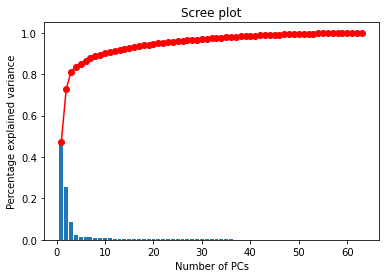

In [22]:
plt.bar(np.arange(len(variance))+1, variance)
plt.plot(np.arange(len(variance))+1, variance.cumsum(),c="red",marker='o')
plt.xlabel("Number of PCs")
plt.ylabel("Percentage explained variance")
plt.title("Scree plot")
plt.show(block=False)

# Passage à l'échelle (5 dossiers de photos complets=2500 photos)

In [1]:
# Chargement des packages et options de configuration

import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:2.7.3,databricks:spark-deep-learning:1.5.0-spark2.4-s_2.11 pyspark-shell --conf spark.driver.extraJavaOptions="-Dio.netty.tryReflectionSetAccessible=true",spark.hadoop.fs.s3a.endpoint=s3.eu-west-1.amazonaws.com'

In [2]:
import findspark
findspark.init()

In [3]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

sc = SparkContext()
spark = SparkSession.builder.master('local[*]').getOrCreate()

In [4]:
import pandas as pd
from PIL import Image,ImageOps,ImageFilter
import numpy as np
import io

In [5]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

from pyspark.sql.functions import col, pandas_udf, PandasUDFType


In [6]:
path = "s3a://p8smonet/more/*"

images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(path)


# Preprocessing des images:

In [7]:
def preprocess(image):
    """
      Preprocesses raw image bytes
      Reshaping en 224,224
      Normalisation d'histogramme
      Filtre Gaussien
      """
    #Je mets tout au format (224,224) en prennant les images chargées en binaire en entrée
    img = Image.open(io.BytesIO(image)).resize([224, 224])    
    #Normalisation d'histogramme
    im2 = ImageOps.equalize(img, mask = None) 
    # Filtre Gaussien
    im3=im2.filter(ImageFilter.GaussianBlur(radius=1))
    #renvoi l'image préprocéssée pour le modèle tensorflow
    return preprocess_input(img_to_array(im3))


# extraction des features

In [8]:
model = ResNet50(weights='imagenet',include_top=False)
model.summary()  # verify that the top layer is removed

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [9]:
#On crée une variable broadcast pour partager entre noeuds les poids de InceptionV3
weights = sc.broadcast(model.get_weights())

def model_features():
    """
    Returns a ResNet50 model with top layer removed and broadcasted pretrained weights from imagenet.
    """
    model = ResNet50(weights=None, include_top=False,pooling='avg')
    model.set_weights(weights.value)
    return model



In [10]:
#On extrait les features:
def featurize_images(model,images_series):
    """
    Extrait le sfeatures d'une série d'images à partir du modèle en entrée.
    :return: une Série des features de l'image
    """
    processed_images = np.stack(images_series.map(preprocess))
    preds = model.predict(processed_images)
    #on transforme la sortie en un vecteur
    output = [p.flatten() for p in preds]
    #on retourne une série de même dimension qu'en entrée
    return pd.Series(output)


In [11]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def udf_featurizer(series_images):
    '''
    Cette méthode est un Itérateur Scalaire Pandas UDF enveloppant notre fonction de featurisation.
    Le décorateur précise que cela renvoie une colonne Spark DataFrame de type ArrayType(FloatType).
  
    series_images est un itérateur sur des lots de données, où chaque lot est une série d'images.
    '''
    model = model_features()
    for images in series_images:
        yield featurize_images(model, images)

/opt/spark/python/pyspark/sql/pandas/functions.py:383: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [12]:
# We can now run featurization on our entire Spark DataFrame.
# NOTE: This can take a long time (about 10 minutes) since it applies a large model to the full dataset.

features_df = images.repartition(3).select(col("path"), udf_featurizer("content").alias("features"))

In [13]:
# Ajout des labels au dataframe de features

from pyspark.sql.functions import split, element_at
#Je récupère l'avant dernier élément de ma liste de chemin vers le fichier de mon image
features_df_labeled = features_df.withColumn('label', element_at(split(features_df['path'],"/"),-2))

In [14]:
features_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [15]:
features_df_labeled.printSchema()

root
 |-- path: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- label: string (nullable = true)



In [16]:
from pyspark.ml.feature import StandardScaler, PCA, VectorAssembler

In [17]:
#Je transforme mes listes de features en vecteur utilisables pour un scaler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

transform_vectors = udf(lambda l: Vectors.dense(l), VectorUDT())

df_vectors = features_df_labeled.select(features_df_labeled["path"],
                                           features_df_labeled["label"],
                                           transform_vectors(features_df_labeled["features"]).alias("features"))

df_vectors.printSchema()


root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)



# Scaling des features

In [19]:
scaler = StandardScaler(inputCol = 'features',outputCol = 'scaledFeatures',withMean = True,withStd = True\
                       ).fit(df_vectors)

# when we transform the dataframe, the old
# feature will still remain in it
df_scaled = scaler.transform(df_vectors)

# Réduction des dimensions

In [20]:
# Détermination du nombre optimal de dimensions pour réduction dimensionnelle des features
from pyspark.ml.feature import PCA

num_components = 2048
pca = PCA(k = num_components,
         inputCol="features", 
          outputCol="features_pca")

reduc = pca.fit(df_scaled)
variance = reduc.explainedVariance

In [21]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['split']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


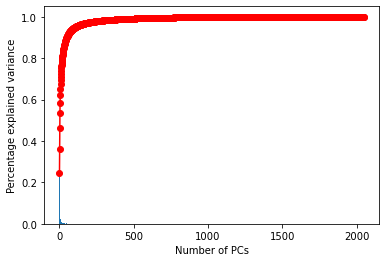

In [22]:
plt.bar(np.arange(len(variance))+1, variance)
plt.plot(np.arange(len(variance))+1, variance.cumsum(),c="red",marker='o')
plt.xlabel("Number of PCs")
plt.ylabel("Percentage explained variance")
plt.show(block=False)

In [23]:
for i in range(500):
    a = variance.cumsum()[i]
    if a >= 0.95:
        print("{} composantes principales expliquent au moins 95% de la variance totale".format(i))
        break

108 composantes principales expliquent au moins 95% de la variance totale


In [24]:
# Réduction dimensionnelle PCA à 108 dimensions

pca = PCA(k=108,inputCol="features",outputCol="features_pca")

In [25]:
final_red= pca.fit(df_scaled)

In [26]:
df_pca = final_red.transform(df_scaled)
df_pca.show(5)

+--------------------+------------------+--------------------+--------------------+--------------------+
|                path|             label|            features|      scaledFeatures|        features_pca|
+--------------------+------------------+--------------------+--------------------+--------------------+
|s3a://p8smonet/mo...|Apple Red Yellow 1|[2.32741069793701...|[2.55752688631536...|[-1.2025496302057...|
|s3a://p8smonet/mo...|Apple Red Yellow 1|[1.82647597789764...|[1.83449346961418...|[0.40978683849273...|
|s3a://p8smonet/mo...|Apple Red Yellow 1|[1.01092672348022...|[0.65735533100964...|[-0.3796348050353...|
|s3a://p8smonet/mo...|Apple Red Yellow 1|[1.31240737438201...|[1.09250301866381...|[-1.1906588785496...|
|s3a://p8smonet/mo...|Apple Red Yellow 1|[1.93201351165771...|[1.98682302588603...|[-0.9971651876305...|
+--------------------+------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [27]:
# Dataframe final avec chemin vers images, labels et features obtenus par PCA

df_final = df_pca[['label','features_pca']]
df_final.show(5)

+------------------+--------------------+
|             label|        features_pca|
+------------------+--------------------+
|Apple Red Yellow 1|[-1.2025496302057...|
|Apple Red Yellow 1|[0.40978683849273...|
|Apple Red Yellow 1|[-0.3796348050353...|
|Apple Red Yellow 1|[-1.1906588785496...|
|Apple Red Yellow 1|[-0.9971651876305...|
+------------------+--------------------+
only showing top 5 rows



In [28]:
# Enregistrement du dataframe final avec la méthode parquet
# Parquet is a columnar format that is supported by many other data processing systems. 
# Spark SQL provides support for both reading and writing Parquet files that automatically preserves the schema of the original data. 
#When reading Parquet files, all columns are automatically converted to be nullable for compatibility reasons.
df_final.write.parquet("s3a://p8smonet/more/features/features.parquet")

In [29]:
# Vérification que les données sont bien chargées

spark.read.parquet("s3a://p8smonet/more/features/features.parquet").show(5)

+------------------+--------------------+
|             label|        features_pca|
+------------------+--------------------+
|Apple Red Yellow 1|[-0.9778233221667...|
|Apple Red Yellow 1|[-0.5817221736814...|
|Apple Red Yellow 1|[-1.2779034890333...|
|Apple Red Yellow 1|[-1.5039096551109...|
|Apple Red Yellow 1|[-1.1729774328178...|
+------------------+--------------------+
only showing top 5 rows



In [30]:
# Transformation en dataframe pandas avec séparation des features dans une colonne dédiée

dfspark = spark.read.parquet("s3a://p8smonet/more/features/features.parquet")
df = dfspark.toPandas()
df.head(3)

,label,features_pca
0,Apple Red Yellow 1,"[-0.9778233221667583, 14.907418764232816, 6.96..."
1,Apple Red Yellow 1,"[-0.5817221736814632, 12.902120464225098, 7.58..."
2,Apple Red Yellow 1,"[-1.2779034890333758, 15.184694348662395, 8.16..."


In [31]:
df.shape

(2198, 2)

In [32]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [33]:
# Création d'un Dataframe avec pour chaque fruit une séparation en colonne de chaque feature identifié

df_final = pd.DataFrame(np.zeros((df.shape[0], 108)))
for i in range(108):
    df_final.loc[:,i] = df["features_pca"].apply(lambda x : x[i])

df_final_pca = pd.concat([df['label'], df_final], axis=1)

In [34]:
df_final_pca.shape

(2198, 109)

In [35]:
df_final_pca.head()

,label,0,1,2,3,4,5,6,7,8,...,98,99,100,101,102,103,104,105,106,107
0,Apple Red Yellow 1,-0.977823,14.907419,6.965158,2.852729,11.748179,-13.711980,4.110166,-7.435070,-4.571912,...,1.244955,-1.126967,0.373650,-1.785598,-1.698658,1.838764,-0.465512,0.759878,-0.398411,0.190925
1,Apple Red Yellow 1,-0.581722,12.902120,7.584030,3.591905,8.839493,-10.173549,5.159060,-9.452771,-3.585344,...,1.896527,-0.502901,-0.034854,-1.260719,-1.810386,1.267842,-0.877851,1.504408,-1.316869,0.087014
2,Apple Red Yellow 1,-1.277903,15.184694,8.169053,3.736156,12.878872,-13.369786,6.651389,-10.384333,-3.486493,...,1.588471,-0.571193,-0.184474,-1.672479,-1.074777,1.143631,-0.036599,1.879805,-0.284636,0.950926
3,Apple Red Yellow 1,-1.503910,12.399289,7.820226,3.663465,8.940321,-10.260368,5.058825,-9.226501,-3.426635,...,1.901382,-0.808344,0.229838,-1.114587,-1.696336,0.755741,0.293704,1.500579,-0.601755,0.058377
4,Apple Red Yellow 1,-1.172977,13.851448,6.432898,3.094607,12.785860,-14.471610,5.203325,-9.110140,-4.600149,...,1.685413,-1.023193,-0.226536,-1.273451,-1.138293,2.159327,-0.214352,1.060438,0.097726,0.466602


In [36]:
df_final.head()

,0,1,2,3,4,5,6,7,8,9,...,98,99,100,101,102,103,104,105,106,107
0,-0.977823,14.907419,6.965158,2.852729,11.748179,-13.711980,4.110166,-7.435070,-4.571912,-2.278313,...,1.244955,-1.126967,0.373650,-1.785598,-1.698658,1.838764,-0.465512,0.759878,-0.398411,0.190925
1,-0.581722,12.902120,7.584030,3.591905,8.839493,-10.173549,5.159060,-9.452771,-3.585344,-2.439954,...,1.896527,-0.502901,-0.034854,-1.260719,-1.810386,1.267842,-0.877851,1.504408,-1.316869,0.087014
2,-1.277903,15.184694,8.169053,3.736156,12.878872,-13.369786,6.651389,-10.384333,-3.486493,-3.745684,...,1.588471,-0.571193,-0.184474,-1.672479,-1.074777,1.143631,-0.036599,1.879805,-0.284636,0.950926
3,-1.503910,12.399289,7.820226,3.663465,8.940321,-10.260368,5.058825,-9.226501,-3.426635,-2.657208,...,1.901382,-0.808344,0.229838,-1.114587,-1.696336,0.755741,0.293704,1.500579,-0.601755,0.058377
4,-1.172977,13.851448,6.432898,3.094607,12.785860,-14.471610,5.203325,-9.110140,-4.600149,-2.601577,...,1.685413,-1.023193,-0.226536,-1.273451,-1.138293,2.159327,-0.214352,1.060438,0.097726,0.466602


In [37]:
# Visualisation des différents fruits par TSNE en 2 dimensions
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2)

X_proj=tsne.fit_transform(df_final)


In [38]:
X_proj

array([[ 59.677887 , -17.321983 ],
       [ 57.21005  , -12.06411  ],
       [ 59.387093 , -13.354257 ],
       ...,
       [ -0.6473018,  52.04677  ],
       [ -1.3761792,  48.816284 ],
       [ -0.9644955,  50.89548  ]], dtype=float32)

In [39]:
TSNE=pd.DataFrame(X_proj)
TSNE=pd.concat([df['label'], TSNE], axis=1)

In [40]:
TSNE

,label,0,1
0,Apple Red Yellow 1,59.677887,-17.321983
1,Apple Red Yellow 1,57.210049,-12.064110
2,Apple Red Yellow 1,59.387093,-13.354257
3,Apple Red Yellow 1,57.769360,-12.176193
4,Apple Red Yellow 1,59.576202,-15.088620
...,...,...,...
2193,Ginger Root,-0.832934,51.393757
2194,Ginger Root,-0.568866,51.756157
2195,Ginger Root,-0.647302,52.046768
2196,Ginger Root,-1.376179,48.816284


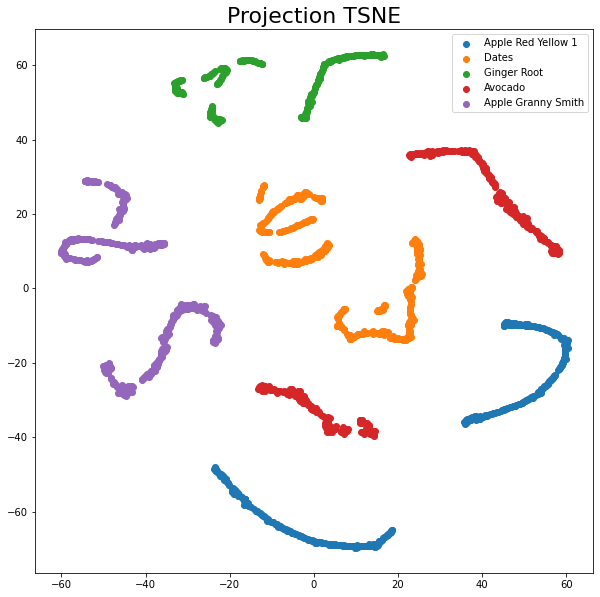

In [41]:


plt.figure(figsize=(10,10))

for fruit in df_final_pca.label.unique():
    d= TSNE[TSNE.label==fruit]
    plt.scatter(d[0], d[1], label=fruit)

plt.title("Projection TSNE",fontsize=22)

plt.legend()    
plt.show()